<a href="https://colab.research.google.com/github/the-bucketless/whockey-notebooks/blob/main/WHKYHAC_Sportlogiq_Data_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examples for Viz Launchpad

I figured I'd make a quick notebook with a few examples of how to use the hockey-rink package for creating visualizations for the [new competition](https://www.whkyhac.com/viz-launchpad) being put on as part of [WHKYHAC](https://www.whkyhac.com/home) this year.  

In [1]:
!pip install hockey-rink -q

  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import files
from hockey_rink import NHLRink, RinkImage
from io import StringIO
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd

## Reading the Data

You have to sign up to get the data, so the play-by-play file will need to be uploaded below and I'm assuming it hasn't been renamed. That might take a few minutes. Alternatively, you could upload the file to your Google Drive which can be mounted in the panel on the left. Then you can uncomment the cells below the uploading section to read it in that way. The file can also just be uploaded to the left panel.  

Attempting to read the csv with the default encoding will cause an error. Seems there are some characters in the data that UTF-8 doesn't like, but ISO-8859-1 seems to get the job done.  

In [3]:
uploaded = files.upload()

Saving 23_PBP_WHKYHAC_SPORTLOGIQ.csv to 23_PBP_WHKYHAC_SPORTLOGIQ.csv


In [4]:
df = pd.read_csv(StringIO(uploaded["23_PBP_WHKYHAC_SPORTLOGIQ.csv"].decode("ISO-8859-1")))

In [3]:
# pbp_filename = ""  #@param {type: "string"}

In [ ]:
# df = pd.read_csv(pbp_filename, encoding="ISO-8859-1")

## Shot Chart

Let's start with the classic single game shot chart. There are different ways of subsetting to a single game, I'm choosing to do it with a groupby. The keys of the groupby can then be used to create a dropdown to select which game you want to see. If you want to change games, select a different game from the dropdown and re-run the cells following it.  

You'll see that I'm a fan of pandas chaining. I've included comments in the chain, so you should be able to break that into separate lines if you prefer.  

The x-coordinates are always relative the offensive team, meaning that everyone's shot will appear on one side of the ice unless they're adjusted. We'll flip the away team's coordinates to have one team on each side.  

In the shot chart, we'll use stars to represent goals and circles for everything else. We'll also use colors from the teams for the markers. Note that these may not be color-blind friendly or complement each other very well. The sizing of the markers is based on Sportlogiq's xG values. It's just something I tried that looked good enough.  

It might be better to subset the shots based on strength-state, but this will look at all of them. As a result, empty net goals can show up as high xG chances from outside the zone.  



In [5]:
team_colors = {
    "Adidas": "#eae12d",
    "Harvey's": "#e88314",
    "Scotiabank": "#c73037",
    "Sonnet": "#7fcfdc",
}

In [6]:
shots_by_game = (
    df
    .query("eventname == 'shot'")
    .groupby(["date", "game"])
)

game_keys = list(shots_by_game.groups.keys())
dropdown_options = [" ".join(game_key) for game_key in game_keys]

In [7]:
print("Select a game:")
game_dropdown = widgets.Dropdown(options=dropdown_options)
game_dropdown

Select a game:


Dropdown(options=('2022-10-15 ADI-HAR', '2022-10-15 SCO-SON', '2022-10-16 ADI-SCO', '2022-10-16 HAR-SON', '202…

In [8]:
game_idx = dropdown_options.index(game_dropdown.value)
game_key = game_keys[game_idx]

game_shots = (
    shots_by_game
    # Subset to the selected game.
    .get_group(game_key)
    .assign(
        # Create a column for each team's primary color.
        team_color=lambda df_: df_.teamname.map(team_colors),
        # Set the marker size based on the xG value.
        marker_size=lambda df_: df_.xg_all_attempts * 500 + 50,
        # Convert home to 1, away to -1 to reflect away shots across center.
        coordinate_side=lambda df_: df_.ishomegame * 2 - 1,
    )
    .assign(
        # Flip away team's coordinates.
        x=lambda df_: df_.xadjcoord * df_.coordinate_side,
        y=lambda df_: df_.yadjcoord * df_.coordinate_side,
    )
)

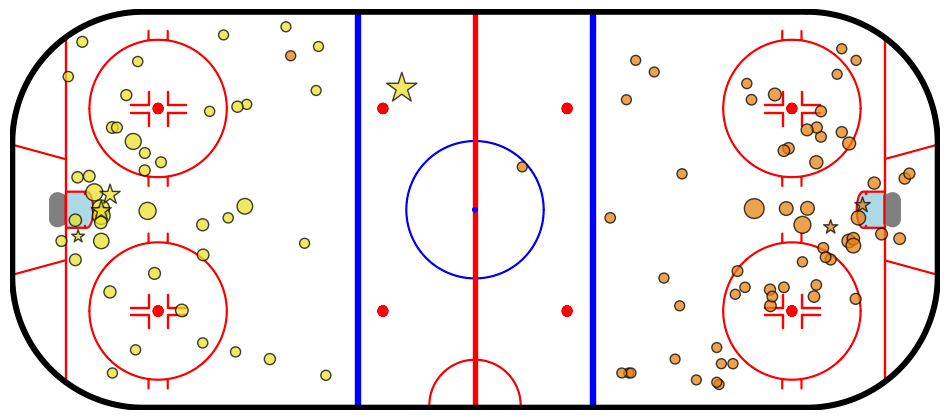

In [11]:
rink = NHLRink()

# Non-goals.
rink.scatter(
    x="x", y="y", 
    color="team_color", s="marker_size",
    data=game_shots.query("goal == 0"),
    edgecolor="black", alpha=0.75,
    draw_kw={"figsize": (12, 6)},
)

# Goals.
rink.scatter(
    x="x", y="y", 
    color="team_color", s="marker_size",
    data=game_shots.query("goal == 1"),
    marker="*",
    edgecolor="black", alpha=0.75,
    draw_kw={"figsize": (12, 6)},
)

plt.show()

## Logo Shot Charts

Next, we'll break the shot charts into separate plots for each team and throw their logo on the ice to identify which shots are theirs. This will use the same game as selected above. If you want a different game, you need to select it from the dropdown and re-run the following cell. But this can be run without running the cell for the full shot chart.  

Since we're doing one plot for each team, we'll end up cutting out shots from outside the offensive zone. We also can use the original coordinates instead of the mirrored coordinates for the away team.  

In addition to the shot charts, we'll add some text displaying the total xG in the game for each team below the plots.  

In [12]:
team_logo_urls = {
    "Adidas": "https://stats.pwhpa.com/wp-content/uploads/2022/10/adidas-icon-150x150.png",
    "Harvey's": "https://stats.pwhpa.com/wp-content/uploads/2022/10/harveys-icon-300x300.png",
    "Scotiabank": "https://stats.pwhpa.com/wp-content/uploads/2022/10/scotiabank-icon-150x150.png",
    "Sonnet": "https://stats.pwhpa.com/wp-content/uploads/2022/10/sonnet-icon-150x150.png",
}

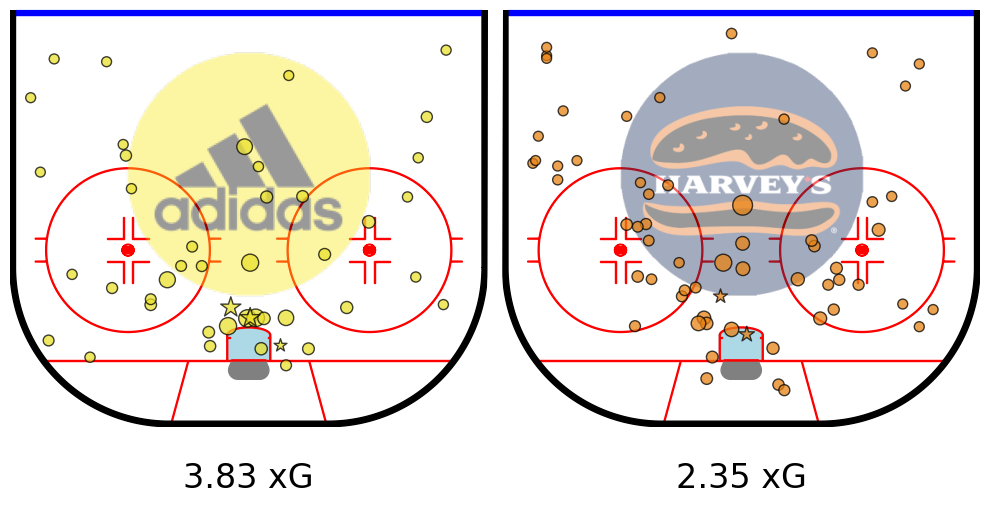

In [13]:
fig, axs = plt.subplots(
    2, 2, 
    figsize=(10, 6), 
    height_ratios=[0.92, 0.08],
    tight_layout=True,
    facecolor="white",
)

for i in range(2):
    team_shots = game_shots.query("ishomegame == @i")
    team_name = team_shots.teamname.iloc[0]

    logo_rink = NHLRink(
        logo={
            "feature_class": RinkImage,
            "image_path": team_logo_urls[team_name],
            # Location and size of the logo.
            "x": 55, "length": 45, "width": 45,
            "zorder": 15, "alpha": 0.4,
            # Because the rink will be rotated, the logo will appear sideways 
            # unless it's also rotated.
            "rotation": 90,
        }
    )
    
    # Non-goals.
    logo_rink.scatter(
        x="xadjcoord", y="yadjcoord",
        color="team_color", s="marker_size",
        data=team_shots.query("goal == 0"),
        edgecolor="black", alpha=0.75,
        ax=axs[0, i],
        draw_kw={"display_range": "ozone", "rotation": 270},
    )

    # Goals.
    logo_rink.scatter(
        x="xadjcoord", y="yadjcoord",
        color="team_color", s="marker_size",
        data=team_shots.query("goal == 1"),
        marker="*", 
        edgecolor="black", alpha=0.75,
        ax=axs[0, i],
        draw_kw={"display_range": "ozone", "rotation": 270},
    )

    # xG text.
    axs[1, i].text(
        0.5, 0.5, 
        f"{round(team_shots.xg_all_attempts.sum(), 2)} xG", 
        ha="center", va="center",
        fontsize=24,
    )
    axs[1, i].axis("off")

## Puck Recoveries

Finally, for something a little different, let's look at some loose puck recoveries (I assume that's what lpr stands for in the event column) from every game. We'll look at this three different ways:

1.   Contour plot
2.   Hexbin
3.   Heatmap

By default, the features of the rink (ie the lines on the rink) may be drawn on top of the plots. Setting the zorder to a higher value ensures the plots are drawn on top while setting an alpha value allows the rink to still be seen.  

When looking at these, keep in mind that play is seen as going from left-to-right. So the left is the defensive zone and the right is the offensive.  

In [14]:
rink = NHLRink()
lpr = df.query("eventname == 'lpr'")

### Contour Plot

You can change the binsize value to have smaller/larger regions contribute to each location's color and the levels value to influence the amount of detail shown.

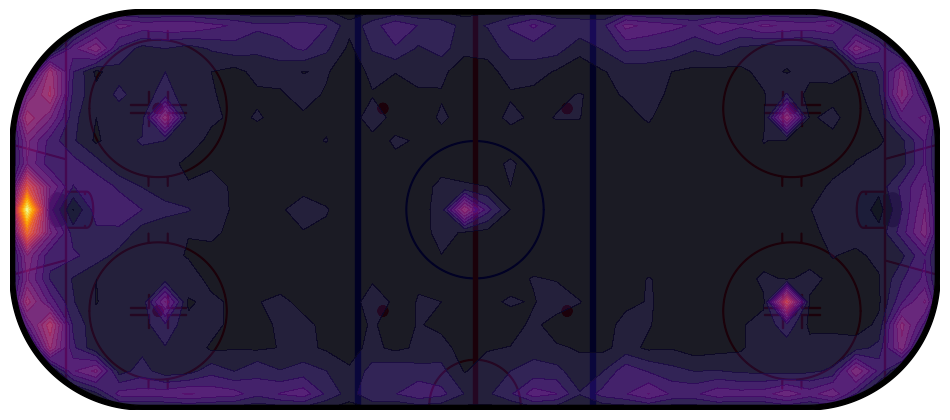

In [15]:
rink.contourf(
    x="xadjcoord", y="yadjcoord", data=lpr,
    binsize=(5, 5), levels=25, 
    reduce_fn="sum",
    zorder=35, alpha=0.9,
    cmap="inferno",
    draw_kw={"figsize": (12, 6)},
)

plt.show()

### Hexbin

You can change the gridsize to make smaller/larger hexagons.

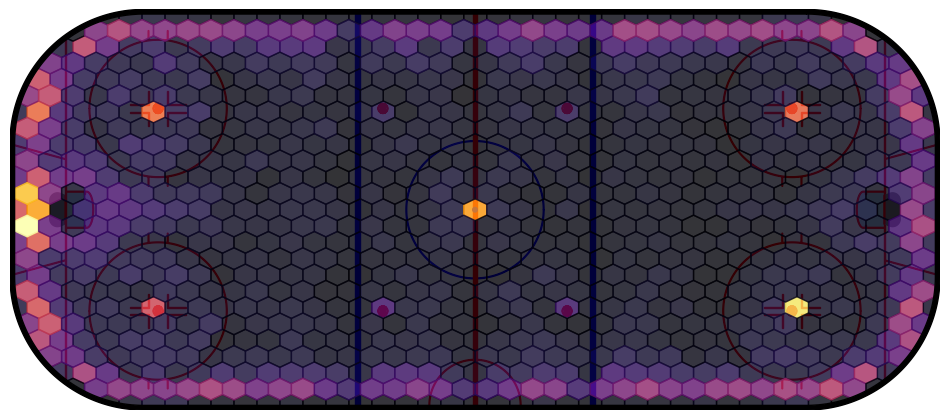

In [16]:
rink.hexbin(
    x="xadjcoord", y="yadjcoord", data=lpr,
    gridsize=(40, 12), 
    zorder=35, alpha=0.8,
    cmap="inferno",
    draw_kw={"figsize": (12, 6)},
)

plt.show()

### Heatmap

This is using really small squares. Changing binsize can make them smaller/larger.  

Setting the plot_range and fill_value parameters ensures that the heatmap will display across the entire surface.  

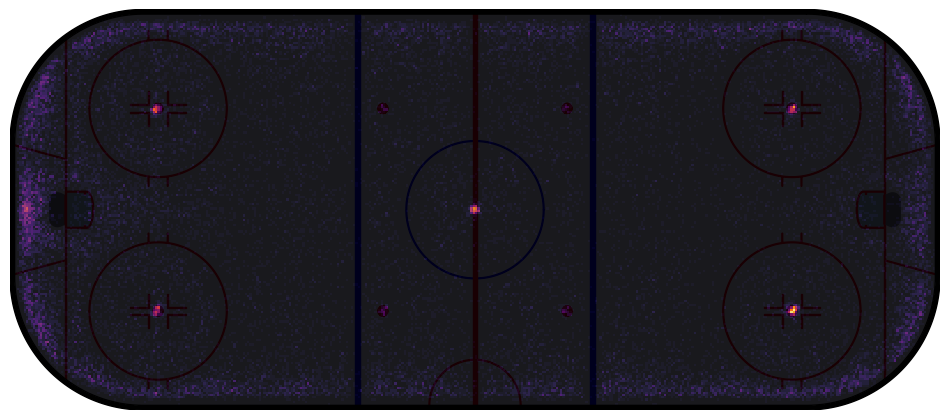

In [17]:
rink.heatmap(
    x="xadjcoord", y="yadjcoord", data=lpr,
    binsize=(0.5, 0.5), 
    reduce_fn="sum",
    fill_value=0, plot_range="full",
    zorder=35, alpha=0.9, cmap="inferno",
    draw_kw={"figsize": (12, 6)},
)

plt.show()

Based on these, it looks like the most common locations for puck recoveries are at the faceoff dots and along the wall. Although, not so much right up against the wall. I wonder if that's just a result of how things are getting annotated.  

The defending team recovering the puck behind their own net is happening frequently, most likely off of dump ins. You can also see that the defensive team is more likely to clean up loose change around their net than the offense is to find rebounds.  